# Taxon definition and lineage

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import toytree
import toyplot
import scipy.stats as sc

import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from adascape.base import IR12SpeciationModel, DD03SpeciationModel
from adascape.fastscape_ext import FastscapeElevationTrait

## Functions to compute and visualize speciation model

In [2]:
def model_run(num_gen=500, init_abundance=10, dt=1e0, taxon_def='traits',
              mut_prob=0.005, sigma_mut=0.05, sigma_env_fitness=0.2, sigma_mov=30, sigma_comp_trait=1.0,
              nb_radius=50, car_cap=50,random_seed=1234, taxon_threshold=0.07):
    
    """
    Function to compute the speciation model.
    Parameters
    ----------            
    num_gen: int
             maximum number of generations to compute.
    init_abundance: int
                    initial number of individuals.
    dt: float
        time step of the simulation
    sigma_env_fitness: float
                     environmental fitness width.
    mut_prob: float
              mutation probability.
    sigma_mut: float
               trait variability of mutated offspring.
    sigma_mov: float
               dispersal variability of offspring
    sigma_comp_trait: float
                      competition variability based on trait among individuals
    nb_radius: int or float
               Radius of the local neighbourhood
    car_cap: int
             Carrying capacity of individuals in the local neighbourhood
    random_seed: int
                 seed of the random number generator
    taxon_threshold: float
                     threshold value to separate taxa in the spectral clustering algorithm.
    taxon_def: str
               If 'traits' taxon are defined as sharing common ancestry and similar trait values
               or if 'traits_location' spatial location is in addition to the previous variables
               included into the clustering algorithm.
    """
    length = (250, 250)
    spacing = (1, 1)
    X, Y = np.meshgrid(*[np.arange(0, l + s, s) for l, s in zip(length, spacing)])
    r = np.random.RandomState(0)
    environment = X + r.rand(*Y.shape)
    trait_01_elev = FastscapeElevationTrait(topo_elevation=environment,
                                        init_trait_min=0.5,
                                        init_trait_max=0.5,
                                        lin_slope=0.95, 
                                        norm_min=environment.min(), 
                                        norm_max=environment.max(), 
                                        random_seed=1234)
    trait_01_elev.initialize()
    init_trait_funcs =  {
    'trait_1': trait_01_elev.init_trait_func,
    }
    opt_trait_funcs = {
    'trait_1': trait_01_elev.opt_trait_func
    }
    
    model = IR12SpeciationModel(X, Y, init_trait_funcs, opt_trait_funcs, init_abundance, 
                                nb_radius=nb_radius, car_cap=car_cap, sigma_env_fitness=sigma_env_fitness, 
                                mut_prob=mut_prob, sigma_mut=sigma_mut, sigma_mov=sigma_mov, 
                                random_seed=random_seed, taxon_threshold=taxon_threshold, 
                                taxon_def=taxon_def, sigma_comp_trait=sigma_comp_trait)

    model.initialize()
    dfs = []
    for step in range(num_gen):
        model.evaluate_fitness(dt)
        dfs.append(model.to_dataframe())
        model.update_individuals(dt)
    return pd.concat(dfs).reset_index(drop=True), environment, X

In [3]:
def plot_sol(dtf, elevation, X):
    num_gen = dtf.step.unique().size
    fig1, axs1 = plt.subplots(2, 2, sharex="col", figsize=(12, 6))
    axs1[0,0].plot(dtf.groupby('step').size())
    h,xedge,yedge,_=axs1[1,0].hist2d(x=dtf['step'], y=dtf['trait_0'],
                                     range=((0, num_gen), (0, 1)),
                                     bins=(num_gen, 100), cmap='bone_r')
    axs1[0, 1].pcolormesh(elevation)
    axs1[0, 1].scatter(dtf['x'].loc[dtf['step']==max(dtf['step'])],
                       dtf['y'].loc[dtf['step']==max(dtf['step'])],
                       c=dtf['trait_0'].loc[dtf['step']==max(dtf['step'])],
                       edgecolor='w',vmin=0, vmax=1)
    h,xedge,yedge,_=axs1[1,1].hist2d(x=dtf['x'].loc[dtf['step']==max(dtf['step'])],
                                     y=dtf['trait_0'].loc[dtf['step']==max(dtf['step'])],
                                     range=((0, X.max()), (0, 1)),
                                     bins=(25, 250), cmap='bone_r')
    axs1[0, 1].yaxis.set_label_position("right")
    axs1[0, 1].yaxis.tick_right()
    axs1[1, 1].yaxis.set_label_position("right")
    axs1[1, 1].yaxis.tick_right()
    axs1[0, 1].set_ylabel('Y', weight='bold')
    axs1[0, 0].set_ylabel('Abundance (No. ind)', weight='bold')
    axs1[1, 1].set_ylabel('Trait', weight='bold')
    axs1[1, 0].set_ylabel('Trait', weight='bold')
    axs1[1, 1].set_xlabel('X', weight='bold')
    axs1[1, 0].set_xlabel('Time (generations)', weight='bold')

In [4]:
def toytree_plot(tree, ind_dtf):
    """
    Plot of phylogenetic tree using library toytree and following the cookbook example 
    https://toytree.readthedocs.io/en/latest/
    
    Parameters
    ----------
    tree : class 'dendropy.tree'
        Phylogenetic tree as class dendropy.tree
    ind_dtf : class 'pandas.DataFrame'
        Speciation model output with data for all individuals
        
    """
    ttree = toytree.tree(tree.as_string(schema='newick'))
    # generate a distribution between 0 and 1 for each tip in the tree
    points = np.linspace(0, 1, 50)
    dists = {}
    for tip in ttree.get_tip_labels():
        trait_values = ind_dtf[ind_dtf.taxon_id==int(tip)].trait_0.values
        if trait_values.size > 1 and trait_values.std() / trait_values.mean() > 1e-10:
            kernel = sc.gaussian_kde(trait_values)                                 
            dists[tip] = kernel(points)
        else:
            dists[tip] = None
    # set up canvas for two panel plot
    canvas = toyplot.Canvas(width=300, height=400)

    # add tree to canvas
    ax0 = canvas.cartesian(bounds=(50, 180, 50, 350), ymin=0, ymax=ttree.ntips, padding=15)
    ttree.draw(axes=ax0, tip_labels=False)
    ax0.show = False

    # add histograms to canvas
    ax1 = canvas.cartesian(bounds=(200, 275, 50, 350), ymin=0, ymax=ttree.ntips, padding=15)

    # iterate from top to bottom (ntips to 0)
    for tip in range(ttree.ntips)[::-1]:

        # select a color for hist
        color = toytree.colors[int((tip) / 100)]

        # get tip name and get hist from dict
        tipname = ttree.get_tip_labels()[tip]
        probs = dists[tipname]
        
        if probs is not None:
            
            # fill histogram with slightly overlapping histograms
            ax1.fill(
                points, probs / probs.max() * 1.25,
                baseline=[tip] * len(points),
                style={"fill": color, "stroke": "white", "stroke-width": 0.5},
                title=tipname,
            )
            # add horizontal line at base
            ax1.hlines(tip, opacity=0.5, color="grey", style={"stroke-width": 0.5})

    # hide y axis, show x
    ax1.y.show = False
    ax1.x.label.text = "Trait value"
    ax1.x.ticks.show = True

## Phylogeny for the speciation model without trait-mediated competition

In [5]:
ind_dtf1, elevation1, X1 = model_run()

In [6]:
ind_dtf1

,step,time,dt,x,y,taxon_id,ancestor_id,n_offspring,fitness,n_all,n_eff,trait_0
0,0,0.0,0.0,244.174942,110.251531,1.0,0.0,4,0.078097,1,1.000000,0.500000
1,0,0.0,0.0,95.048934,152.467702,1.0,0.0,14,0.854469,3,3.000000,0.500000
2,0,0.0,0.0,230.811558,215.905324,1.0,0.0,7,0.131384,1,1.000000,0.500000
3,0,0.0,0.0,65.423106,215.939418,1.0,0.0,7,0.525148,4,4.000000,0.500000
4,0,0.0,0.0,79.774265,168.720328,1.0,0.0,9,0.700492,4,4.000000,0.500000
...,...,...,...,...,...,...,...,...,...,...,...,...
182870,499,499.0,0.0,93.031921,55.969702,1064.0,1061.0,1,0.908986,38,37.371912,0.293153
182871,499,499.0,0.0,139.777484,41.441883,1064.0,1061.0,0,0.418002,46,42.619728,0.293153
182872,499,499.0,0.0,22.910352,12.750687,1064.0,1061.0,1,0.674072,37,36.575346,0.293153
182873,499,499.0,0.0,24.206601,65.828392,1064.0,1061.0,1,0.685045,50,49.517583,0.293153


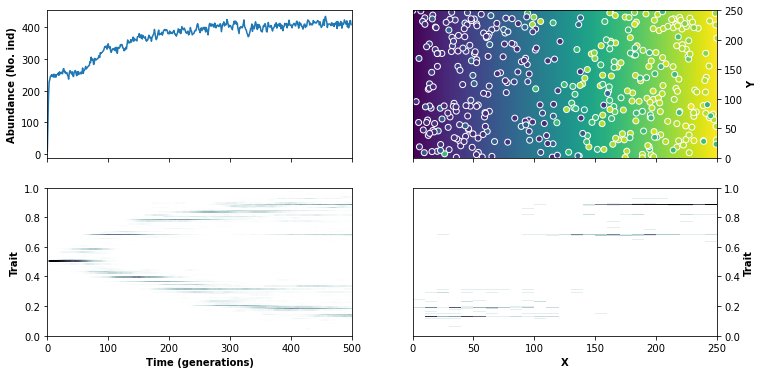

In [7]:
plot_sol(ind_dtf1, elevation1, X1)

In [8]:
taxon_lineage1 = ind_dtf1.ptree.extract_taxon_summary()
taxon_lineage1

,time,taxon_id,ancestor_id,trait_0,abundance,node_type
0,0.0,1,0,0.500000,10,root
1,1.0,2,1,0.499862,99,node
2,2.0,3,2,0.499779,185,node
3,3.0,4,3,0.499793,228,node
4,4.0,5,4,0.500040,234,node
...,...,...,...,...,...,...
1061,498.0,1062,1059,0.883152,149,node
1062,498.0,1063,1060,0.682449,69,node
1063,499.0,1064,1061,0.182319,197,leaf
1064,499.0,1065,1062,0.881148,146,leaf


In [9]:
tree1 = ind_dtf1.ptree.to_dendropy_tree()

In [10]:
tree1.print_plot()

                  ++++++++++++++++++++++++++++++++++++++++++++++++++++++++ 1064
+++++++++++++++++++                                                            
                  |                          +++++++++++++++++++++++++++++ 1065
                  ++++++++++++++++++++++++++++                                 
                                             +++++++++++++++++++++++++++++ 1066
                                                                               
                                                                               


In [11]:
toytree_plot(tree1, ind_dtf1)

<svg class="toyplot-canvas-Canvas" xmlns:toyplot="http://www.sandia.gov/toyplot" xmlns:xlink="http://www.w3.org/1999/xlink" xmlns="http://www.w3.org/2000/svg" width="300.0px" height="400.0px" viewBox="0 0 300.0 400.0" preserveAspectRatio="xMidYMid meet" style="background-color:transparent;border-color:#292724;border-style:none;border-width:1.0;fill:rgb(16.1%,15.3%,14.1%);fill-opacity:1.0;font-family:Helvetica;font-size:12px;opacity:1.0;stroke:rgb(16.1%,15.3%,14.1%);stroke-opacity:1.0;stroke-width:1.0" id="t766b43d2dace40dca667d162921e6e7d"> <polygon points="200.0,150.0 201.53061224489795,150.0 203.0612244897959,150.0 204.59183673469389,150.0 206.12244897959187,150.0 207.6530612244898,150.0 209.18367346938774,150.0 210.71428571428572,150.0 212.24489795918367,150.0 213.77551020408163,150.0 215.30612244897958,150.0 216.83673469387753,150.0 218.36734693877548,150.0 219.8979591836735,150.0 221.42857142857144,150.0 222.9591836734694,150.0 224.48979591836735,150.0 226.0204081632653,150.0 227.55102040816325,150.0 229.0816326530612,150.0 230.61224489795916,150.0 232.1428571428571,150.0 233.6734693877551,150.0 235.20408163265304,150.0 236.73469387755102,150.0 238.26530612244898,150.0 239.79591836734693,150.0 241.3265306122449,150.0 242.85714285714286,150.0 244.3877551020408,150.0 245.91836734693877,150.0 247.44897959183675,150.0 248.9795918367347,150.0 250.51020408163265,150.0 252.0408163265306,150.0 253.57142857142858,150.0 255.10204081632654,150.0 256.6326530612245,150.0 258.16326530612247,150.0 259.6938775510204,150.0 261.2244897959184,150.0 262.7551020408163,150.0 264.2857142857143,150.0 265.81632653061223,150.0 267.3469387755102,150.0 268.8775510204082,150.0 270.4081632653061,150.0 271.9387755102041,150.0 273.469387755102,150.0 275.0,150.0 275.0,150.0 273.469387755102,150.0 271.9387755102041,150.0 270.4081632653061,150.0 268.8775510204082,150.0 267.3469387755102,150.0 265.81632653061223,150.0 264.2857142857143,150.0 262.7551020408163,150.0 261.2244897959184,150.0 259.6938775510204,150.0 258.16326530612247,150.0 256.6326530612245,150.0 255.10204081632654,150.0 253.57142857142858,150.0 252.0408163265306,150.0 250.51020408163265,150.0 248.9795918367347,150.0 247.44897959183675,150.0 245.91836734693877,150.0 244.3877551020408,150.0 242.85714285714286,150.0 241.3265306122449,150.0 239.79591836734693,150.0 238.26530612244898,149.99999999999994 236.73469387755102,149.99999999994236 235.20408163265304,149.99999996790183 233.6734693877551,149.99999244552313 232.1428571428571,149.99924738849478 230.61224489795916,149.96815781693135 229.0816326530612,149.42397976648073 227.55102040816325,145.48016758581525 226.0204081632653,134.1129701336317 224.48979591836735,123.03989947399926 222.9591836734694,124.15955420755671 221.42857142857144,132.39272614913324 219.8979591836735,138.05820494556195 218.36734693877548,136.42976075864732 216.83673469387753,124.16724393287141 215.30612244897958,95.58594491678213 213.77551020408163,68.13301989702614 212.24489795918367,44.77778470432128 210.71428571428572,25.000000000000025 209.18367346938774,55.89833693566461 207.6530612244898,113.04601668791614 206.12244897959187,142.19072876170165 204.59183673469389,148.13496493326267 203.0612244897959,149.1666287659841 201.53061224489795,149.775655442694 200.0,149.97377206193823" style="fill:rgb(40%,76.1%,64.7%);fill-opacity:1.0;opacity:1.0;stroke:rgb(100%,100%,100%);stroke-opacity:1.0;stroke-width:0.5"> 1064 <polygon points="200.0,250.00000000000003 201.53061224489795,250.00000000000003 203.0612244897959,250.00000000000003 204.59183673469389,250.00000000000003 206.12244897959187,250.00000000000003 207.6530612244898,250.00000000000003 209.18367346938774,250.00000000000003 210.71428571428572,250.00000000000003 212.24489795918367,250.00000000000003 213.77551020408163,250.00000000000003 215.30612244897958,250.00000000000003 216.83673469387753,250.00000000000003 218.36734693877548,250.00000000000003 219.8979591836735,250.00000000000003 221.42857142857144,250.00000000000003 

## Tree summary statistics 

Phylogenetic diversity (PD)

In [12]:
sum(tree1.calc_node_root_distances())

1497.0

In [13]:
pdm1=tree1.phylogenetic_distance_matrix()

Mean pairwise distance (MPD)

In [14]:
pdm1.mean_pairwise_distance()

627.3333333333334

Mean neighbor taxon distance (MNTD)

In [15]:
pdm1.mean_nearest_taxon_distance()

504.6666666666667

Lineages through time (LTT)

Text(0, 0.5, 'Number of Lineages')

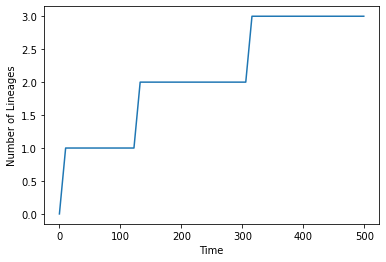

In [16]:
time_steps1 = np.linspace(0, tree1.max_distance_from_root(), 50)
ltt1=[tree1.num_lineages_at(t) for t in time_steps1]
plt.plot(time_steps1, ltt1)
plt.xlabel('Time')
plt.ylabel('Number of Lineages')

## Phylogeny for the speciation model with trait-mediated competition

In [17]:
ind_dtf2, elevation2, X2 = model_run(sigma_comp_trait=0.20, car_cap=30)

In [18]:
ind_dtf2

,step,time,dt,x,y,taxon_id,ancestor_id,n_offspring,fitness,n_all,n_eff,trait_0
0,0,0.0,0.0,244.174942,110.251531,1.0,0.0,2,0.078097,1,1.000000,0.500000
1,0,0.0,0.0,95.048934,152.467702,1.0,0.0,9,0.854469,3,3.000000,0.500000
2,0,0.0,0.0,230.811558,215.905324,1.0,0.0,4,0.131384,1,1.000000,0.500000
3,0,0.0,0.0,65.423106,215.939418,1.0,0.0,4,0.525148,4,4.000000,0.500000
4,0,0.0,0.0,79.774265,168.720328,1.0,0.0,5,0.700492,4,4.000000,0.500000
...,...,...,...,...,...,...,...,...,...,...,...,...
145993,499,499.0,0.0,17.457590,169.977227,1286.0,1281.0,1,0.399812,31,17.614683,0.362987
145994,499,499.0,0.0,42.944095,232.972629,1286.0,1281.0,1,0.690482,35,21.466345,0.362987
145995,499,499.0,0.0,34.267638,248.406973,1286.0,1281.0,1,0.581294,28,16.952983,0.362987
145996,499,499.0,0.0,15.071818,248.596156,1286.0,1281.0,1,0.380213,19,11.323670,0.362987


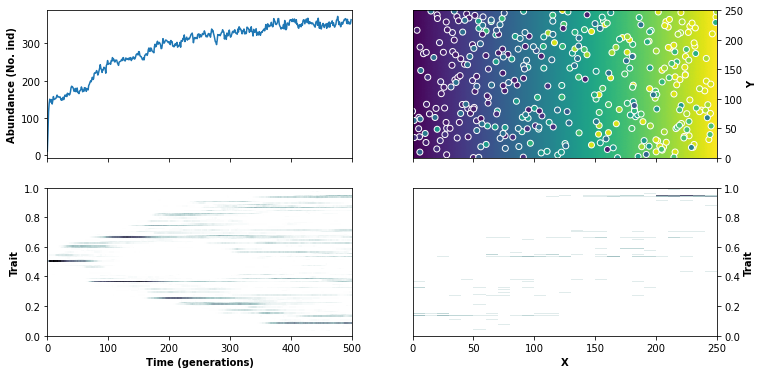

In [19]:
plot_sol(ind_dtf2, elevation2, X2)

In [20]:
taxon_lineage2 = ind_dtf2.ptree.extract_taxon_summary()
taxon_lineage2

,time,taxon_id,ancestor_id,trait_0,abundance,node_type
0,0.0,1,0,0.500000,10,root
1,1.0,2,1,0.500718,58,node
2,2.0,3,2,0.501475,116,node
3,3.0,4,3,0.500929,138,node
4,4.0,5,4,0.500778,150,node
...,...,...,...,...,...,...
1283,499.0,1284,1279,0.918237,89,leaf
1284,499.0,1285,1280,0.619423,107,leaf
1285,499.0,1286,1281,0.372061,52,leaf
1286,499.0,1287,1282,0.101281,97,leaf


In [21]:
tree2 = ind_dtf2.ptree.to_dendropy_tree()

In [22]:
tree2.print_plot()

                                                 +++++++++++++++++++++++++ 1284
         +++++++++++++++++++++++++++++++++++++++++                             
         |                                       +++++++++++++++++++++++++ 1285
++++++++++                                                                     
         |                                      ++++++++++++++++++++++++++ 1286
         ++++++++++++++++++++++++++++++++++++++++                              
                                                |                      +++ 1287
                                                ++++++++++++++++++++++++       
                                                                       +++ 1288
                                                                               
                                                                               


In [23]:
toytree_plot(tree2, ind_dtf2)

<svg class="toyplot-canvas-Canvas" xmlns:toyplot="http://www.sandia.gov/toyplot" xmlns:xlink="http://www.w3.org/1999/xlink" xmlns="http://www.w3.org/2000/svg" width="300.0px" height="400.0px" viewBox="0 0 300.0 400.0" preserveAspectRatio="xMidYMid meet" style="background-color:transparent;border-color:#292724;border-style:none;border-width:1.0;fill:rgb(16.1%,15.3%,14.1%);fill-opacity:1.0;font-family:Helvetica;font-size:12px;opacity:1.0;stroke:rgb(16.1%,15.3%,14.1%);stroke-opacity:1.0;stroke-width:1.0" id="t943cda700ab540bc9f811f7dbb8c9340"> <polygon points="200.0,109.99999999999999 201.53061224489795,109.99999999999999 203.0612244897959,109.99999999999999 204.59183673469389,109.99999999999999 206.12244897959187,109.99999999999999 207.6530612244898,109.99999999999999 209.18367346938774,109.99999999999999 210.71428571428572,109.99999999999999 212.24489795918367,109.99999999999999 213.77551020408163,109.99999999999999 215.30612244897958,109.99999999999999 216.83673469387753,109.99999999999999 218.36734693877548,109.99999999999999 219.8979591836735,109.99999999999999 221.42857142857144,109.99999999999999 222.9591836734694,109.99999999999999 224.48979591836735,109.99999999999999 226.0204081632653,109.99999999999999 227.55102040816325,109.99999999999999 229.0816326530612,109.99999999999999 230.61224489795916,109.99999999999999 232.1428571428571,109.99999999999999 233.6734693877551,109.99999999999999 235.20408163265304,109.99999999999999 236.73469387755102,109.99999999999999 238.26530612244898,109.99999999999999 239.79591836734693,109.99999999999999 241.3265306122449,109.99999999999999 242.85714285714286,109.99999999999999 244.3877551020408,109.99999999999999 245.91836734693877,109.99999999999999 247.44897959183675,109.99999999999999 248.9795918367347,109.99999999999999 250.51020408163265,109.99999999999999 252.0408163265306,109.99999999999999 253.57142857142858,109.99999999999999 255.10204081632654,109.99999999999999 256.6326530612245,109.99999999999999 258.16326530612247,109.99999999999999 259.6938775510204,109.99999999999999 261.2244897959184,109.99999999999999 262.7551020408163,109.99999999999999 264.2857142857143,109.99999999999999 265.81632653061223,109.99999999999999 267.3469387755102,109.99999999999999 268.8775510204082,109.99999999999999 270.4081632653061,109.99999999999999 271.9387755102041,109.99999999999999 273.469387755102,109.99999999999999 275.0,109.99999999999999 275.0,109.07295907648722 273.469387755102,105.12625341958801 271.9387755102041,70.35459627203257 270.4081632653061,34.999999999999986 268.8775510204082,83.38140098856275 267.3469387755102,103.41444111071337 265.81632653061223,85.40406338031968 264.2857142857143,81.56136281524746 262.7551020408163,102.50728963004576 261.2244897959184,109.33704747702355 259.6938775510204,109.98321754523789 258.16326530612247,109.99992223879877 256.6326530612245,109.99999994342264 255.10204081632654,109.99999999999372 253.57142857142858,109.99999999999999 252.0408163265306,109.99999999999999 250.51020408163265,109.99999999999999 248.9795918367347,109.99999999999999 247.44897959183675,109.99999999999999 245.91836734693877,109.99999999999999 244.3877551020408,109.99999999999999 242.85714285714286,109.99999999999999 241.3265306122449,109.99999999999999 239.79591836734693,109.99999999999999 238.26530612244898,109.99999999999999 236.73469387755102,109.99999999999999 235.20408163265304,109.99999999999999 233.6734693877551,109.99999999999999 232.1428571428571,109.99999999999999 230.61224489795916,109.99999999999999 229.0816326530612,109.99999999999999 227.55102040816325,109.99999999999999 226.0204081632653,109.99999999999999 224.48979591836735,109.99999999999999 222.9591836734694,109.99999999999999 221.42857142857144,109.99999999999999 219.8979591836735,109.99999999999999 218.36734693877548,109.99999999999999 216.83673469387753,109.99999999999999 215.30612244897958,109.99999999999999 213.77551020408163,109.99999999999999 212.24489795918367,109.99999999999999 210.71428571428572,109.9999

## Tree summary statistics 

Phylogenetic diversity (PD)

In [24]:
sum(tree2.calc_node_root_distances())

2495.0

In [25]:
pdm2=tree2.phylogenetic_distance_matrix()

Mean pairwise distance (MPD)

In [26]:
pdm2.mean_pairwise_distance()

626.6

Mean neighbor taxon distance (MNTD)

In [27]:
pdm2.mean_nearest_taxon_distance()

214.4

Lineages through time (LTT)

Text(0, 0.5, 'Number of Lineages')

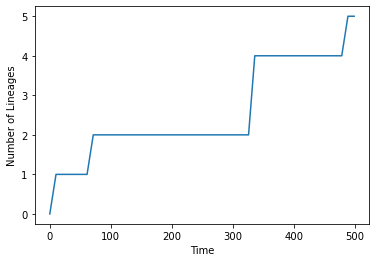

In [28]:
time_steps2 = np.linspace(0, tree2.max_distance_from_root(), 50)
ltt2 = [tree2.num_lineages_at(t) for t in time_steps2]
plt.plot(time_steps2, ltt2)
plt.xlabel('Time')
plt.ylabel('Number of Lineages')